In [1]:
!pip install segmentation_models
!pip install -qq -U wandb
import tensorflow as tf
import cv2
import numpy as np
import os
import glob
import keras
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
import matplotlib.pyplot as plt
import wandb
from wandb.integration.keras import WandbMetricsLogger

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 88.1 MB/s eta 0:00:00
Segmentation Models: using `tf.keras` framework.


In [2]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_login = user_secrets.get_secret("wandb")

In [3]:
SIZE_X = 512
SIZE_Y = 512
n_classes = 2
# channels_to_keep = [0,1,2,5]
BATCH_SIZE = 8
AUTOTUNE = tf.data.AUTOTUNE
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])
wandb.login(key=wandb_login)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: modiperin (ljuniversity) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

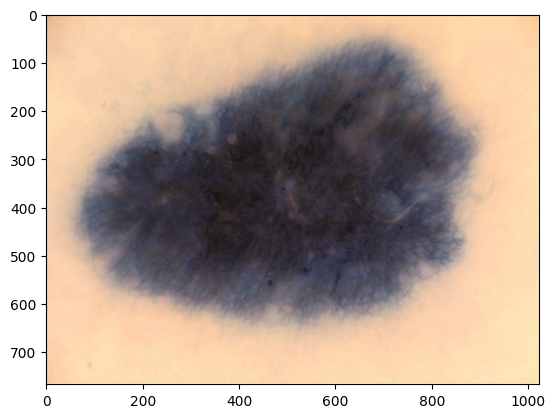

In [4]:
img='/kaggle/input/skin-cancer/Skin Cancer/train/images/ISIC_0000000.jpg'
msk='/kaggle/input/skin-cancer/Skin Cancer/train/masks/ISIC_0000000_Segmentation.png'
image=cv2.imread(img)
plt.imshow(image)

In [5]:
image.shape

(767, 1022, 3)

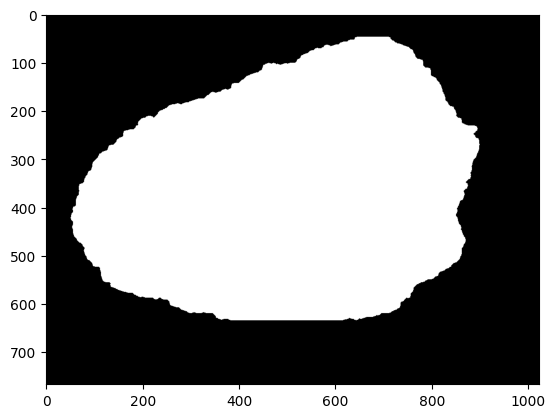

In [6]:
mask=cv2.imread(msk)
plt.imshow(mask)

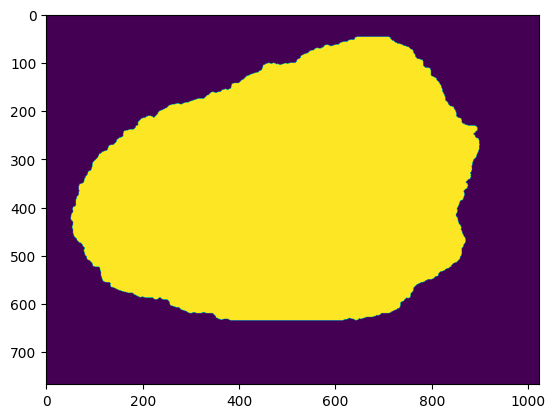

In [7]:
plt.imshow(mask[:,:,2])

In [8]:
def preprocess_and_augment(image, mask):
#     image = image.numpy()
#     mask = mask.numpy()
#     image, mask = augment_image(image, mask)  # Apply augmentations
#     image = tf.convert_to_tensor(image, dtype=tf.float32)
#     mask = tf.convert_to_tensor(mask, dtype=tf.float32)
    image = image / 255.0
    image = (image - IMAGENET_MEAN) / IMAGENET_STD  # Apply ImageNet normalization
#     print(mask.shape)
    mask = tf.squeeze(mask, axis=-1)
#     print(mask.shape)
    mask = tf.one_hot(tf.cast(mask, tf.int32), depth=n_classes)
#     print(mask.shape)
#     channels_to_keep = [1,2,3,4,5,6]
#     print(n_cla)
    # mask = tf.gather(mask, indices=channels_to_keep, axis=-1)

# The shape should now be (512, 512, 4)
#     print(mask.shape)
    return image, mask

In [9]:
import tensorflow as tf
import os
from segmentation_models import get_preprocessing

# Configuration

base_path = "/kaggle/input/skin-cancer/Skin Cancer/train"
image_path = os.path.join(base_path, "images")
mask_path = os.path.join(base_path, "masks")

# Loading image datasets
image_dataset = tf.keras.utils.image_dataset_from_directory(
    image_path,
    labels=None,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(SIZE_Y, SIZE_X),
    shuffle=False
)

# Loading mask datasets
mask_dataset = tf.keras.utils.image_dataset_from_directory(
    mask_path,
    labels=None,
    color_mode='grayscale',  # Masks are grayscale
    batch_size=BATCH_SIZE,
    image_size=(SIZE_Y, SIZE_X),
    shuffle=False
)

# Combine datasets
dataset = tf.data.Dataset.zip((image_dataset, mask_dataset))

# Apply preprocessing
dataset = dataset.map(preprocess_and_augment, num_parallel_calls=AUTOTUNE)

# Split into train and validation sets
dataset_size = tf.data.experimental.cardinality(dataset).numpy() * BATCH_SIZE
train_size = int(0.8 * dataset_size)

train_dataset = dataset.take(train_size // BATCH_SIZE)
val_dataset = dataset.skip(train_size // BATCH_SIZE)

# Shuffle and prefetch datasets
train_dataset = train_dataset.shuffle(buffer_size=1000).prefetch(AUTOTUNE)
val_dataset = val_dataset.prefetch(AUTOTUNE)

Found 900 files.
Found 900 files.


(8, 512, 512, 3)
(8, 512, 512, 2)


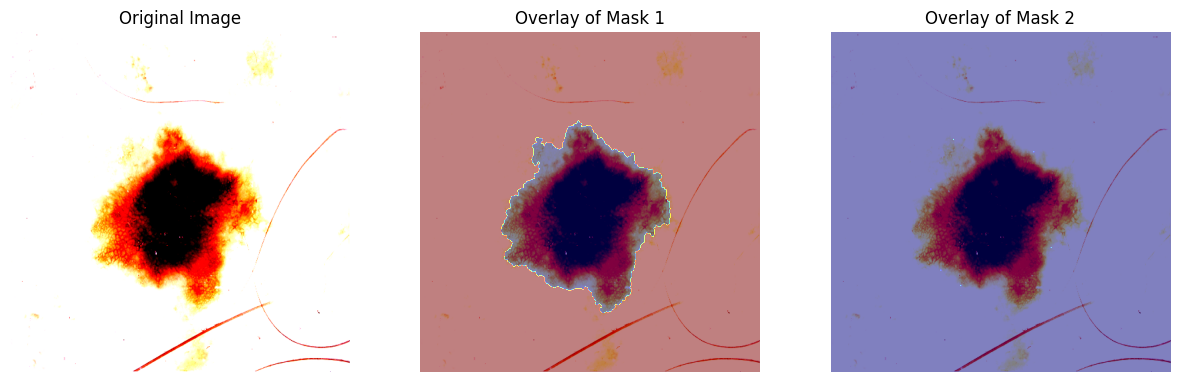

(8, 512, 512, 3)
(8, 512, 512, 2)


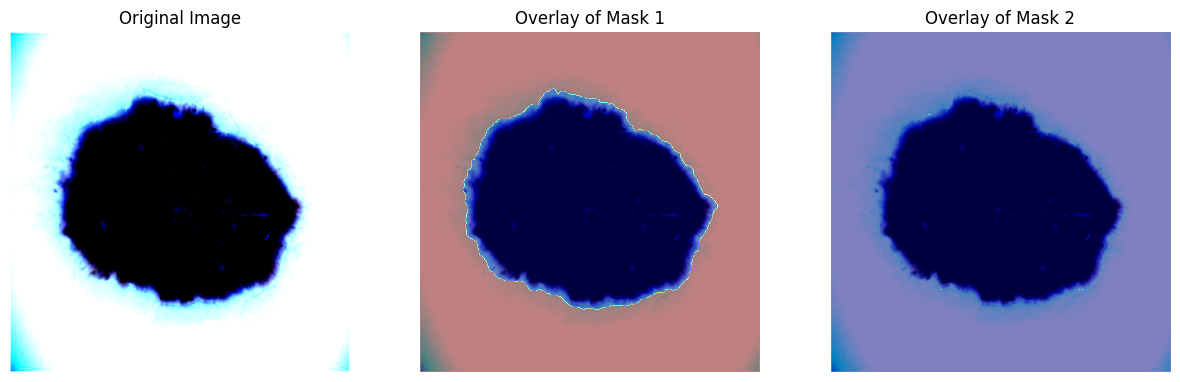

(8, 512, 512, 3)
(8, 512, 512, 2)


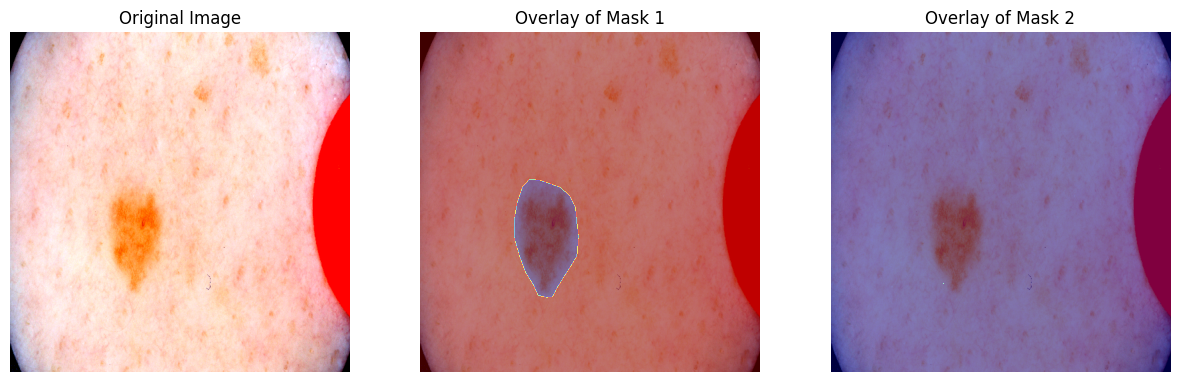

(8, 512, 512, 3)
(8, 512, 512, 2)


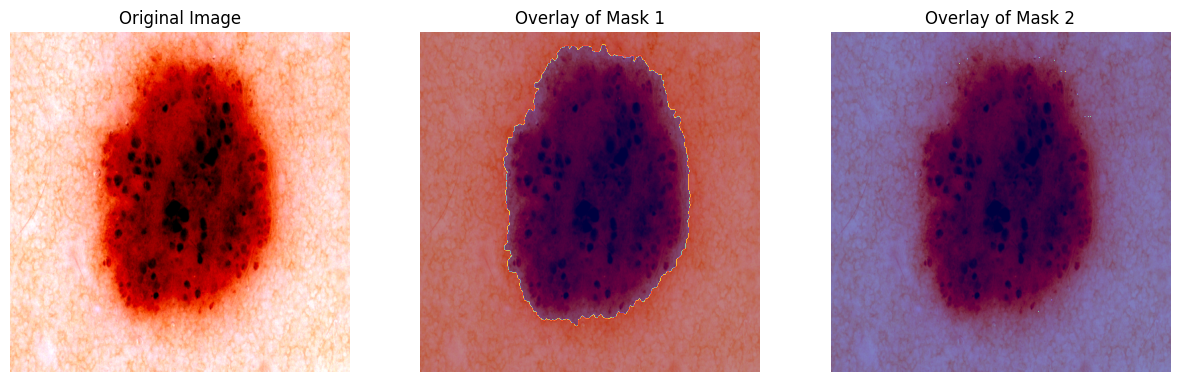

(8, 512, 512, 3)
(8, 512, 512, 2)


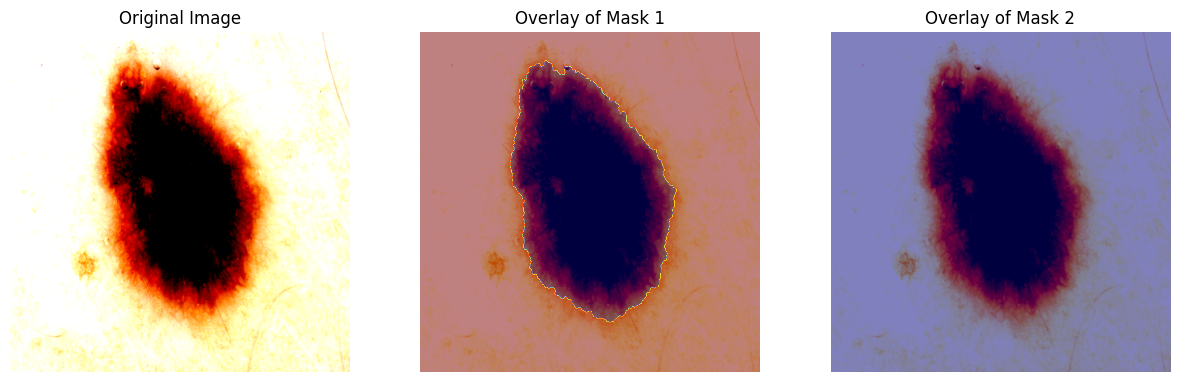

In [10]:
for images,masks in train_dataset.skip(10).take(5):
    plt.figure(figsize=(15, 15))
    # Plot original image
    plt.subplot(3, 3, 1)  # Subplot for the image
    print(images.shape)
    print(masks.shape)
    plt.imshow(images[0,:,:,:])  # Show the image in RGB
    plt.title("Original Image")
    plt.axis('off')

    # Loop through each mask channel and overlay on the image
    for i in range(2):  # Assuming 7 classes/mask channels
        plt.subplot(3, 3, i+2)  # Subplots for each mask
        plt.imshow(images[0,:,:,:])  # Show the original image
        plt.imshow(masks[0,:, :, i], cmap='jet', alpha=0.5)  # Overlay mask i
        plt.title(f'Overlay of Mask {i+1}')
        plt.axis('off')

    plt.show()

In [11]:
mask_dataset = tf.keras.utils.image_dataset_from_directory(
    mask_path,
    labels=None,
    color_mode='grayscale',  # Masks are grayscale
    batch_size=BATCH_SIZE,
    image_size=(SIZE_Y, SIZE_X),
    shuffle=True
)

Found 900 files.


In [12]:
masks = []
for mask_batch in mask_dataset:
    masks.append(mask_batch.numpy())

In [13]:
masks = np.concatenate(masks, axis=0)

In [14]:
import numpy as np
import tensorflow as tf
import segmentation_models as sm

# n_classes = 7  # Number of classes in your segmentation task

def calculate_class_frequencies(masks, n_classes):
    # Initialize an array to store pixel counts for each class
    class_frequencies = np.zeros(n_classes)
    
    # Loop over the masks and count pixels in each class
    for mask in masks:
        # Flatten mask and count occurrences of each class
        unique, counts = np.unique(mask, return_counts=True)
        for cls, count in zip(unique.astype(int), counts):  # Convert cls to int
            if cls < n_classes:  # Ensure cls is within the number of classes
                class_frequencies[cls] += count

    return class_frequencies

def compute_class_weights(frequencies):
    # Inverse frequency to give more weight to less frequent classes
    total_pixels = np.sum(frequencies)
    class_weights = total_pixels / (frequencies + 1e-6)  # Add a small epsilon to avoid division by zero
    
    # Normalize the weights so they sum to 1 (optional)
    class_weights = class_weights / np.sum(class_weights)
    
    return class_weights

def weighted_dice_loss(weights):
    def dice_loss(y_true, y_pred):
        smooth = 1e-6
        y_true_f = tf.keras.backend.flatten(y_true)
        y_pred_f = tf.keras.backend.flatten(y_pred)

        # Multiply each class by its corresponding weight
        weighted_true = y_true_f * weights
        weighted_pred = y_pred_f * weights

        intersection = tf.reduce_sum(weighted_true * weighted_pred)
        return 1 - (2. * intersection + smooth) / (tf.reduce_sum(weighted_true) + tf.reduce_sum(weighted_pred) + smooth)

    return dice_loss

# Calculate class frequencies using the masks variable
class_frequencies = calculate_class_frequencies(masks, 2)

# Compute class weights based on frequencies
class_weights = compute_class_weights(class_frequencies)
print(class_weights)

# Create a weighted Dice Loss using the calculated weights
# loss = weighted_dice_loss(class_weights)

[8.54829426e-06 9.99991452e-01]


In [15]:
import segmentation_models as sm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
# from tensorflow.keras.models import Model

# Set the parameters
BACKBONE = 'vgg19'  
LR = 0.0004  # Learning rate

# Define the model
model = sm.Unet(
    backbone_name=BACKBONE,
    encoder_weights='imagenet',
    input_shape=(SIZE_Y, SIZE_X, 3),  # Input image shape
    classes=n_classes,
    activation='sigmoid'  # For multi-class segmentation
)

# Compile the model with relevant losses and metrics
dice_loss=sm.losses.DiceLoss(class_weights=class_weights)
focal_loss=sm.losses.CategoricalFocalLoss()
total_loss =  dice_loss + (2*focal_loss) 
# Combination of losses
metrics = ['accuracy',sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5),tf.keras.metrics.TopKCategoricalAccuracy(k=5, name="top@5_accuracy")]  # IOU and F1

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0004), 
#               loss=loss, 
#               metrics=['accuracy'])

# # Model summary
model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 512, 512, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 512, 512, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 256, 256, 64)   │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 256, 256, 128)  │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 256, 256, 128)  │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 128, 128, 128)  │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 128, 128, 256)  │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 128, 128, 256)  │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 128, 128, 256)  │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv4 (Conv2D)     │ (None, 128, 128, 256)  │        590,080 │ block3_conv3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 64, 64, 256)    │              0 │ block3_conv4[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 64, 64, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 64, 64, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 64, 64, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv4 (Conv2D)     │ (None, 64, 64, 512)    │      2,359,808 │ block4_conv3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 32, 32, 512)    │              0 │ block4_conv4[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)

 Total params: 29,062,114 (110.86 MB)

 Trainable params: 29,058,082 (110.85 MB)

 Non-trainable params: 4,032 (15.75 KB)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(
    monitor='val_f1-score',        # Monitor validation loss
    patience=5,                 # Number of epochs with no improvement after which training will stop
    mode='max',
    restore_best_weights=True  # Restore model to the best state
)

checkpoint = ModelCheckpoint(
    'sigmoid_skin_cancer_vgg19_unfreeze.keras',  # Path to save the model
    monitor='val_f1-score',  # Metric to monitor ('val_accuracy' if using validation set)
    save_best_only=True,  # Only save the model if the monitored metric improves
    mode='max',  # Save the model with the highest accuracy
    verbose=1
)

In [17]:
LR=0.0001
epochs=100
configs = dict(
    num_classes=7,
    shuffle_buffer=1024,
    batch_size=8,
    image_size=512,
    image_channels=2,
    learning_rate=LR,
    epochs=epochs,
)
run = wandb.init(project="sigmoid_skin_cancer_vgg19_unfreeze", config=configs)
# Phase 1: Train decoder with frozen encoder
# for layer in model.layers:
#     if 'decoder' not in layer.name.split('_'):
#         layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss=loss, metrics=metrics)
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset,callbacks=[checkpoint,early_stopping,WandbMetricsLogger(log_freq=10)])
run.finish()

wandb: Tracking run with wandb version 0.19.8
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250330_070854-fov2puc5
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run dutiful-durian-2
wandb: ⭐️ View project at https://wandb.ai/ljuniversity/sigmoid_skin_cancer_vgg19_unfreeze
wandb: 🚀 View run at https://wandb.ai/ljuniversity/sigmoid_skin_cancer_vgg19_unfreeze/runs/fov2puc5


NameError: name 'loss' is not defined

In [ ]:
import numpy as np
import tensorflow as tf
from PIL import Image

def preprocess_image(image_path):
    # Load image
    image = Image.open(image_path).convert("RGB")
    image = image.resize((SIZE_X, SIZE_Y))
    image = np.array(image) / 255.0
    
    # Normalize using ImageNet stats
    image = (image - IMAGENET_MEAN) / IMAGENET_STD
    
    # Convert to tensor and add batch dimension
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.expand_dims(image, axis=0)
    
    return image

In [ ]:
# model.save('/kaggle/working/sigmoid_skin_cancer_resnet34_unfreeze.keras')

In [ ]:
# from keras.models import load_model
# model_res=load_model('/kaggle/working/sigmoid_skin_cancer_resnet34_unfreeze.keras',compile=False)

In [ ]:
# predicted_mask=model_res.predict(preprocess_image('/kaggle/input/skin-cancer/Skin Cancer/train/images/ISIC_0000000.jpg'))

In [ ]:
# plt.imshow(preprocess_image('/kaggle/input/skin-cancer/Skin Cancer/train/images/ISIC_0000000.jpg')[0])

In [ ]:
# plt.imshow(predicted_mask[0,:,:,0])